# Variational Quantum Circuits (VQC) - Lab 

In [1]:
import numpy as np
import scipy
from scipy.linalg import expm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

In [2]:
def breast_cancer(training_size, test_size, n, PLOT_DATA=True):
    class_labels = [r'Benign', r'Malignant']
    
    # First the dataset must be imported.
    cancer = datasets.load_breast_cancer()

    X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.3, random_state=109)

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    pca = PCA(n_components=n).fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    samples = np.append(X_train, X_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    X_train = minmax_scale.transform(X_train)
    X_test = minmax_scale.transform(X_test)

    X_train_input = {key: (X_train[y_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    X_test_input = {key: (X_train[y_train == k, :])[training_size:(training_size+test_size)] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, 2):
            x_axis_data = X_train[y_train == k, 0][:training_size]
            y_axis_data = X_train[y_train == k, 1][:training_size]
            
            label = 'Malignant' if k == 1 else 'Benign'
            plt.scatter(x_axis_data, y_axis_data, label=label)

        plt.title("Breast Cancer Dataset (Dimensionality Reduced With PCA)")
        plt.legend()
        plt.show()

    return X_train, y_train, X_test, y_test


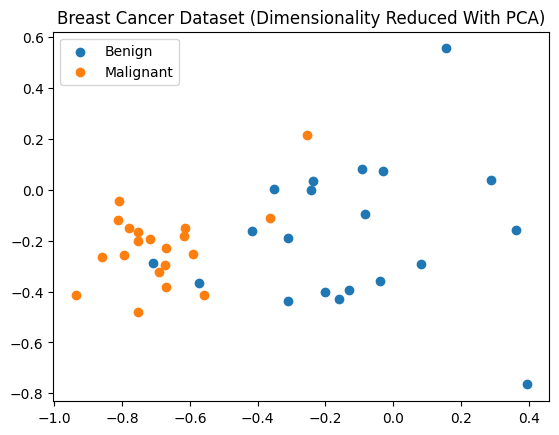

In [3]:
from qiskit_machine_learning.utils import algorithm_globals

n = 2 # How many features to use (dimensionality)
training_dataset_size = 20
testing_dataset_size = 10
X_train, y_train, X_test, y_test = breast_cancer(training_dataset_size, testing_dataset_size, n)

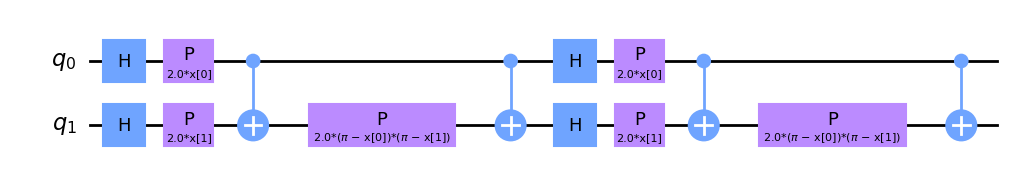

In [4]:
from qiskit.circuit.library import ZZFeatureMap
num_features = X_train.shape[1]
num_qubits = num_features 
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

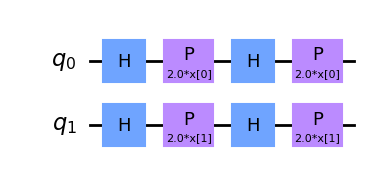

In [5]:
from qiskit.circuit.library import ZFeatureMap
num_features = X_train.shape[1]
num_qubits = num_features 
feature_map = ZFeatureMap(feature_dimension=num_features, reps=2)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

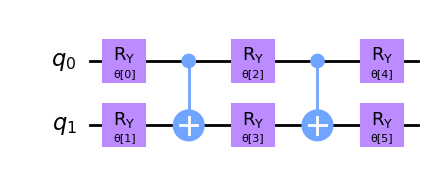

In [6]:
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(num_qubits=num_features, reps=2)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

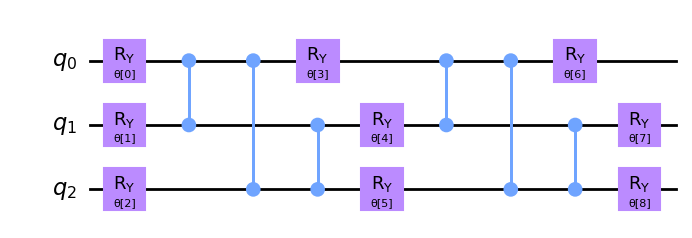

In [7]:
from qiskit.circuit.library import TwoLocal
ry = TwoLocal(3, "ry", "cz", reps=2)
ry.decompose().draw(output="mpl", style="clifford", fold=20)

In [12]:
from qiskit_machine_learning.optimizers import COBYLA
optimizer = COBYLA(maxiter=30)

In [13]:
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.primitives import StatevectorSampler as Sampler
sampler = Sampler()

In [14]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

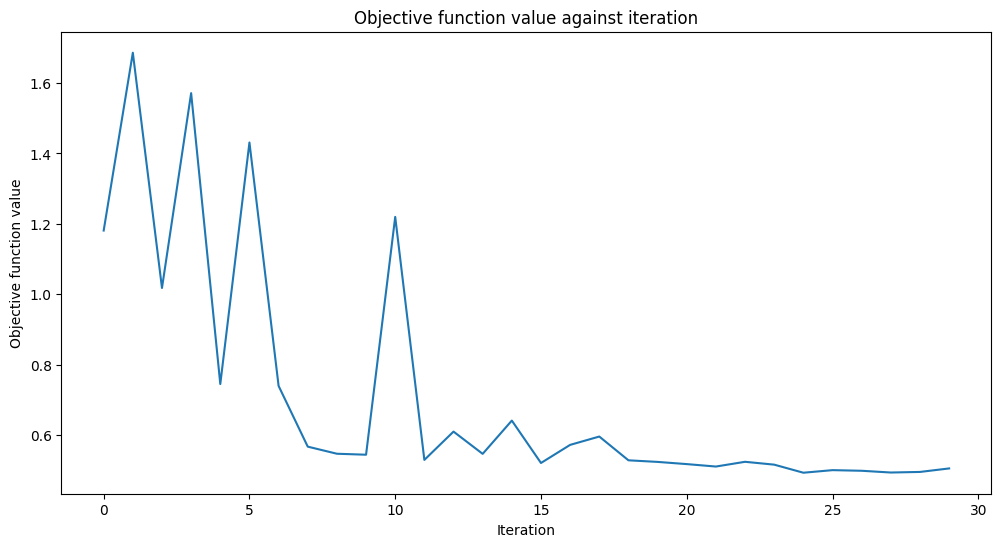

Training time: 123 seconds


In [15]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X_train, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [16]:
train_score_q4 = vqc.score(X_train, y_train)
test_score_q4 = vqc.score(X_test, y_test)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.90
Quantum VQC on the test dataset:     0.93
